In [1]:
!pip install autokeras -q

     |████████████████████████████████| 174kB 6.0MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 


# 6.2.2 Tune autoencoder model for unsupervised learning

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AutoencoderModel(Model):
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder_layer = layers.Dense(latent_dim, activation='relu')
    self.decoder_layer = layers.Dense(784, activation='sigmoid')

  def encode(self, encoder_input):
    encoder_output = layers.Flatten()(encoder_input)
    encoder_output = self.encoder_layer(encoder_output)
    return encoder_output

  def decode(self, decoder_input):
    decoder_output = decoder_input
    decoder_output = self.decoder_layer(decoder_output)
    decoder_output = layers.Reshape((28, 28))(decoder_output)
    return decoder_output

  def call(self, x):
    return self.decode(self.encode(x))

In [5]:
import numpy as np

tf.random.set_seed(5)
np.random.seed(5)
autoencoder = AutoencoderModel(64)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.evaluate(x_test, x_test)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0402 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0090


0.008974517695605755

In [6]:
autoencoder.encode(x_test[:3])

<tf.Tensor: shape=(3, 64), dtype=float32, numpy=
array([[ 3.931118  ,  1.0182607 ,  6.5596466 ,  2.8951714 ,  1.5840772 ,
         2.3559613 ,  2.0955122 ,  4.4853425 ,  1.34939   ,  3.600976  ,
         3.548002  ,  1.0803884 ,  3.5926104 ,  2.34089   ,  0.        ,
         1.3521023 ,  1.5423646 ,  3.7132359 ,  2.201931  ,  1.3938733 ,
         0.9601338 ,  2.3903034 ,  1.4392248 ,  2.155833  ,  4.1962905 ,
         3.8109841 ,  3.2413573 ,  1.1022322 ,  2.7478027 ,  0.        ,
         6.340748  ,  2.589056  ,  1.905628  ,  0.6149954 ,  1.742942  ,
         0.59232974,  2.512223  ,  1.4705787 ,  1.579788  ,  2.3179786 ,
         0.1933682 ,  1.6040548 ,  1.8269951 ,  2.1929228 ,  3.5982947 ,
         2.1040351 ,  3.4453387 ,  3.4056275 ,  3.693409  ,  2.5358927 ,
         2.8133378 ,  4.46262   ,  2.030352  ,  3.790924  ,  2.4032135 ,
         2.2115893 ,  2.5821419 ,  1.4490023 ,  2.3869803 ,  0.        ,
         3.2467706 ,  1.1970179 ,  0.5150781 ,  0.7152041 ],
       [ 2.326

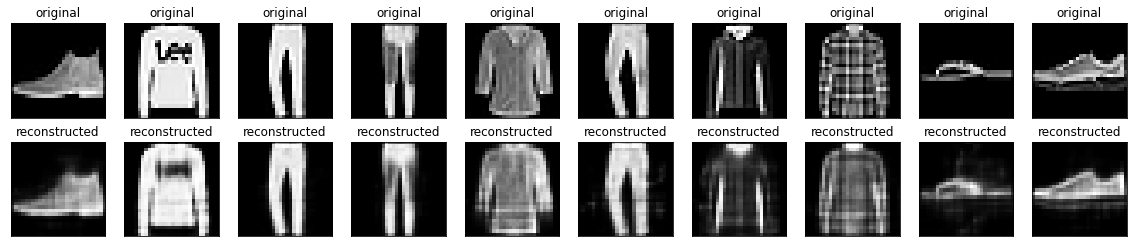

In [7]:
import matplotlib.pyplot as plt

def show_images(model, images):
  encoded_imgs = model.encode(images).numpy()
  decoded_imgs = model.decode(encoded_imgs).numpy()

  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

show_images(autoencoder, x_test)

In [13]:
import kerastuner
from tensorflow import keras
from kerastuner import RandomSearch

class AutoencoderBlock(keras.Model):
  def __init__(self, latent_dim, hp):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder_layers = []
    for i in range(hp.Int("encoder_layers",
                          min_value=0,
                          max_value=2,
                          step=1,
                          default=0)):
      self.encoder_layers.append(
          layers.Dense(units=hp.Choice("encoder_layers_{i}".format(i=i),
                                       [64, 128, 256]),
                       activation='relu'))
    self.encoder_layers.append(layers.Dense(latent_dim, activation='relu'))
    self.decoder_layers = []
    for i in range(hp.Int("decoder_layers",
                          min_value=0,
                          max_value=2,
                          step=1,
                          default=0)):
      self.decoder_layers.append(
          layers.Dense(units=hp.Choice("decoder_layers_{i}".format(i=i),
                                       [64, 128, 256]),
                       activation='relu'))
    self.decoder_layers.append(layers.Dense(784, activation='sigmoid'))

  def encode(self, encoder_input):
    encoder_output = layers.Flatten()(encoder_input)
    for layer in self.encoder_layers:
      encoder_output = layer(encoder_output)
    return encoder_output

  def decode(self, decoder_input):
    decoder_output = decoder_input
    for layer in self.decoder_layers:
      decoder_output = layer(decoder_output)
    decoder_output = layers.Reshape((28, 28))(decoder_output)
    return decoder_output

  def call(self, x):
    return self.decode(self.encode(x))

In [14]:
def build_model(hp):
  autoencoder = AutoencoderBlock(64, hp)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='my_dir',
    project_name='helloworld')

tuner.search(x_train, x_train,
             epochs=10,
             validation_data=(x_test, x_test))

Trial 10 Complete [00h 01m 03s]
val_loss: 0.00914884451776743

Best val_loss So Far: 0.007596543058753014
Total elapsed time: 00h 09m 16s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in my_dir/helloworld
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_layers: 0
decoder_layers: 2
decoder_layers_0: 256
encoder_layers_0: 64
encoder_layers_1: 128
decoder_layers_1: 256
Score: 0.007596543058753014
313/313 [==============================] - 1s 2ms/step - loss: 0.0075


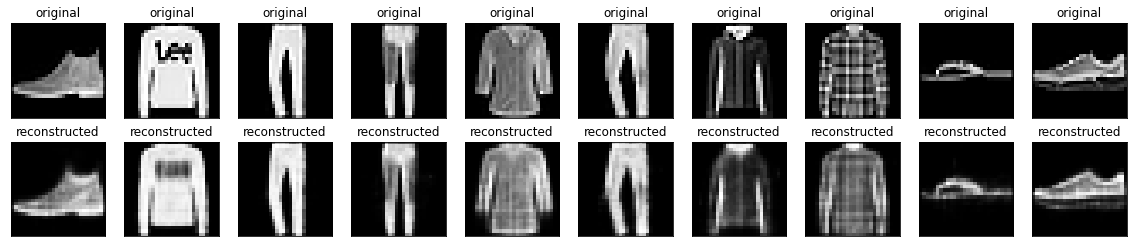

In [15]:
autoencoder = tuner.get_best_models(num_models=1)[0]
tuner.results_summary(1)
autoencoder.evaluate(x_test, x_test)

show_images(autoencoder, x_test)